In [11]:
# Gerekli Kütüphaneler
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [12]:
# Veri Yükleme ve Etiket Ayırma
try:
    # Eğitim ve test veri setleri yükleniyor (kaggle formunda)
    train_df = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_train.csv")
    test_df = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_test.csv")
except FileNotFoundError:
    # Dosyalar bulunamazsa program durduruluyor.
    print("HATA: CSV dosyaları belirtilen yolda bulunamadı. Lütfen dosya yollarınızı kontrol edin.")
    raise

# Etiketlere ayırma adımı.
y_train_labels = train_df['label'].values
X_train_pixels = train_df.drop('label', axis=1).values
y_test_labels = test_df['label'].values
X_test_pixels = test_df.drop('label', axis=1).values 

# Projedeki sınıf sayısı
NUM_CLASSES = 24

# Yeniden şekillendirme (modelin istediği 4 boyutlu görüntü formatına uyarlama)
X_train = X_train_pixels.reshape(-1, 28, 28, 1)
X_test = X_test_pixels.reshape(-1, 28, 28, 1)

# Normalizasyon (0-1 aralığına getirip modelin hızlı öğrenmesini sağlıyrouz.)
X_train = X_train / 255.0
X_test = X_test / 255.0

print(f"Eğitim veri seti boyutu: {X_train.shape}")
print(f"Test veri seti boyutu: {X_test.shape}")
print(f"Sınıf sayısı: {NUM_CLASSES}")

Eğitim veri seti boyutu: (27455, 28, 28, 1)
Test veri seti boyutu: (7172, 28, 28, 1)
Sınıf sayısı: 24


In [13]:
# J (9) ve Z (25) harflerine karşılık gelen resimler bulunmadığı için 9'u atlayıp sonrakileri bir basamak kaydırdım.
def remap_labels(labels):
    new_labels = np.zeros_like(labels)
    for old_label in np.unique(labels):
        if old_label < 9:
            new_label = old_label
        elif old_label > 9:
            new_label = old_label - 1 # J atlandı.
        
        # y_train ve y_test güncellendi.
        new_labels[labels == old_label] = new_label
    return new_labels

y_train_labels_remapped = remap_labels(y_train_labels)
y_test_labels_remapped = remap_labels(y_test_labels)

# One hot encode etiketleri (Hangi sınıfın aktif olduğunu görüyoruz.)
y_train = to_categorical(y_train_labels_remapped, NUM_CLASSES)
y_test = to_categorical(y_test_labels_remapped, NUM_CLASSES)

# Eğitim ve doğrulama veri setlerine ayırma
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

print(f"Eğitim için resim: {X_train_final.shape}, Etiket: {y_train_final.shape}")
print(f"Doğrulama için resim: {X_val.shape}, Etiket: {y_val.shape}")

Eğitim için resim: (24709, 28, 28, 1), Etiket: (24709, 24)
Doğrulama için resim: (2746, 28, 28, 1), Etiket: (2746, 24)


In [14]:
# Veri büyütme (overfitting'i önlemek için)
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.10,
    shear_range=0.10,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train_final, y_train_final, batch_size=64)
val_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=64)
test_generator = ImageDataGenerator().flow(X_test, y_test, batch_size=64)

Başta girdiğim değerlerden sonra overfitting yaşandı. Daha sonrasında değerleri değiştirdim ve sorun çözüldü.

In [15]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=X_train_final.shape[1:]),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.40), 

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.40), 
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.6), 
    
    Dense(NUM_CLASSES, activation='softmax')
])

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │        12,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,686,264 (6.43 MB)

 Trainable params: 1,684,856 (6.43 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [16]:
# Callbacks
# val_accuracy 15 epoch boyunca ilerlemezse durdurur. İlerleme yavaşlarsa hızını düşürür.
earlystop = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6, mode='max')

# Model Eğitimi
print("Model Eğitimi")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100, # Max epoch sayısı
    callbacks=[earlystop, reduce_lr],
    verbose=1
)


Model Eğitimi
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


387/387 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.2033 - loss: 3.4367 - val_accuracy: 0.2462 - val_loss: 2.3363 - learning_rate: 5.0000e-04
Epoch 2/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5872 - loss: 1.2936 - val_accuracy: 0.9144 - val_loss: 0.2938 - learning_rate: 5.0000e-04
Epoch 3/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.7445 - loss: 0.7675 - val_accuracy: 0.9308 - val_loss: 0.2090 - learning_rate: 5.0000e-04
Epoch 4/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.8164 - loss: 0.5399 - val_accuracy: 0.9909 - val_loss: 0.0613 - learning_rate: 5.0000e-04
Epoch 5/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.8672 - loss: 0.4086 - val_accuracy: 0.9953 - val_loss: 0.0369 - learning_rate: 5.0000e-04
Epoch 6/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.8968 - loss: 0.3063 - val_accuracy: 0.9894 - val_loss: 0.0453 - learning_rate: 5.0000e-04
Epoch 7/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accurac

Model Değerlendirmesi
Test verisi üzerinde kayıp: 0.0117
Test verisi üzerinde doğruluk: 0.9997


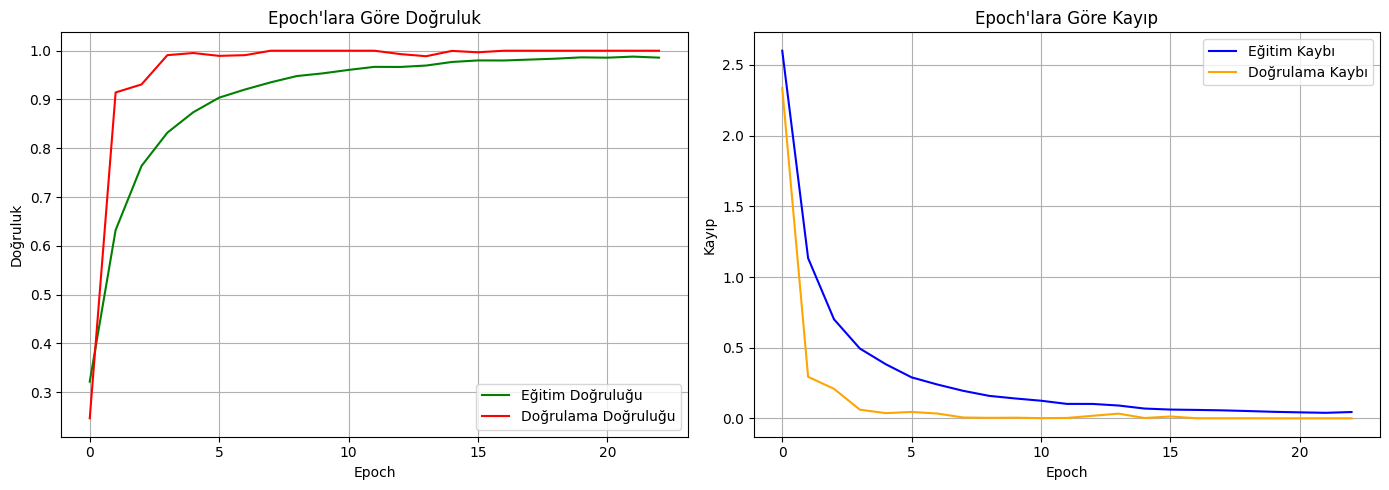

In [17]:
print("Model Değerlendirmesi")
loss, accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test verisi üzerinde kayıp: {loss:.4f}")
print(f"Test verisi üzerinde doğruluk: {accuracy:.4f}")

plt.figure(figsize=(14, 5))

# Doğruluk
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu', color='green')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', color='red')
plt.title('Epoch\'lara Göre Doğruluk')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

# Kayıp
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı', color='blue')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı', color='orange')
plt.title('Epoch\'lara Göre Kayıp')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Sınıflara Göre Örnek Resimler Oluşturuluyor 


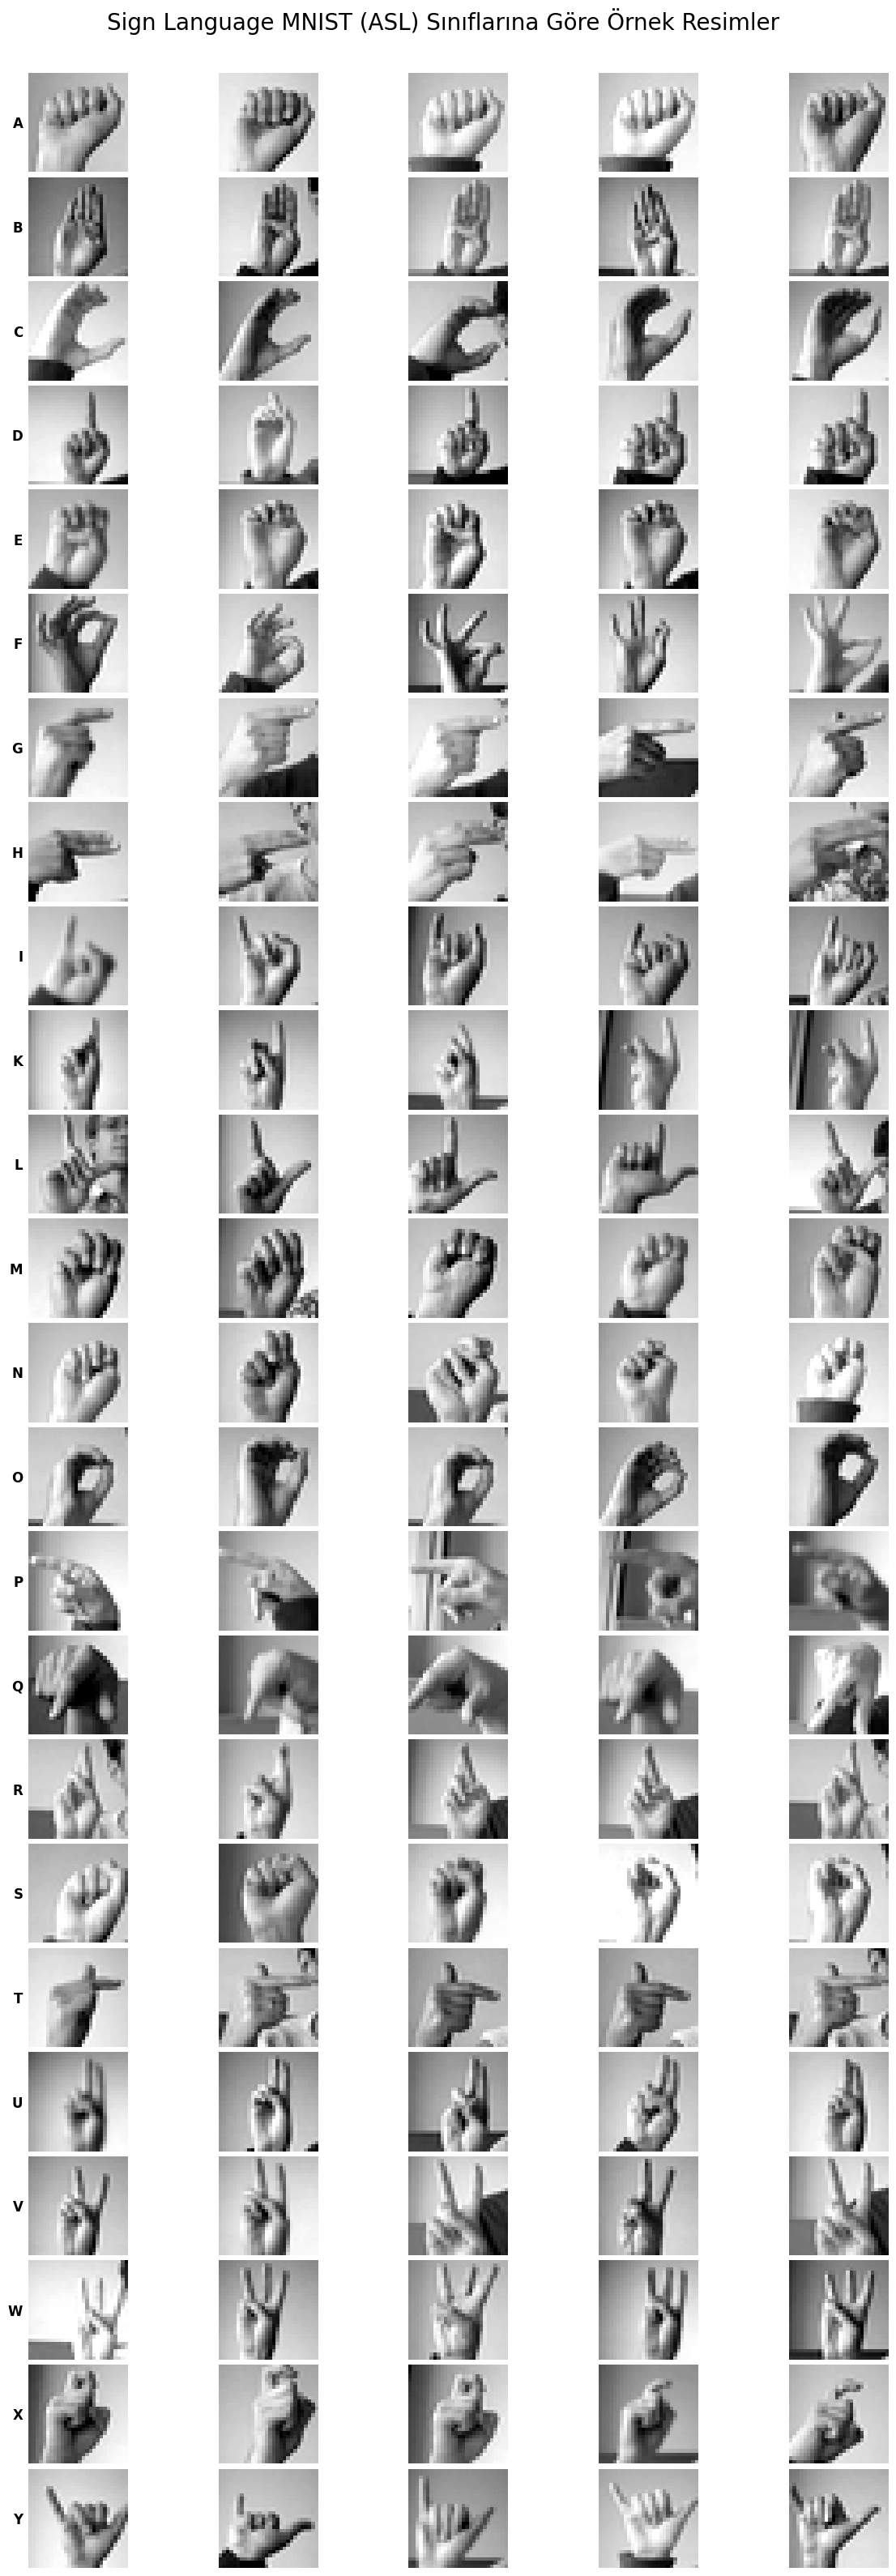

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

try:
    train_df = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_train.csv")
except:
    print("HATA: train_df yüklenemedi. Lütfen yolu kontrol ediniz...")
    raise

y_train_labels = train_df['label'].values
X_train_pixels = train_df.drop('label', axis=1).values

IMG_DIM = 28
NUM_CLASSES = 24

# J ve Z harflerinin atlanması dikkate alındı.
alphabet_map = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',
    # J-9
    10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
    18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'
    # Z-25
}

# Görselleştirme başlamta
num_samples_per_class = 5
fig, axes = plt.subplots(NUM_CLASSES, num_samples_per_class, figsize=(15, 40))
plt.subplots_adjust(wspace=0.05, hspace=0.05)

print("Sınıflara Göre Örnek Resimler Oluşturuluyor ")

for i in range(NUM_CLASSES): # 0'dan 23'e
    
    # J için +1
    original_label = i
    if i >= 9:
        original_label += 1
    
    class_samples = X_train_pixels[y_train_labels == original_label]
    
    if len(class_samples) == 0:
        print(f"Uyarı: Etiket {original_label} için örnek bulunamadı.")
        continue

    # her sınıf için 5 örnek alındı.
    sample_indices = np.random.choice(len(class_samples), num_samples_per_class, replace=False)
    
    for j, idx in enumerate(sample_indices):
        img_data = class_samples[idx].reshape(IMG_DIM, IMG_DIM)
        
        axes[i, j].imshow(img_data, cmap='gray')
        axes[i, j].axis('off')
        
        if j == 0:
            axes[i, j].text(-2, IMG_DIM // 2, alphabet_map.get(original_label, f"S:{original_label}"), 
                            fontsize=12, fontweight='bold', va='center', ha='right')
        
plt.suptitle('Sign Language MNIST (ASL) Sınıflarına Göre Örnek Resimler', fontsize=20, y=0.9)
plt.show()

**Her bir harf sınıfından beşer tane örnek alınmıştır. Veri setindeki görüntüleri görmüş oluyoruz.**

Test verisi üzerinde tahminler alınıyor
Karmaşıklık Matrisi oluşturuluyor


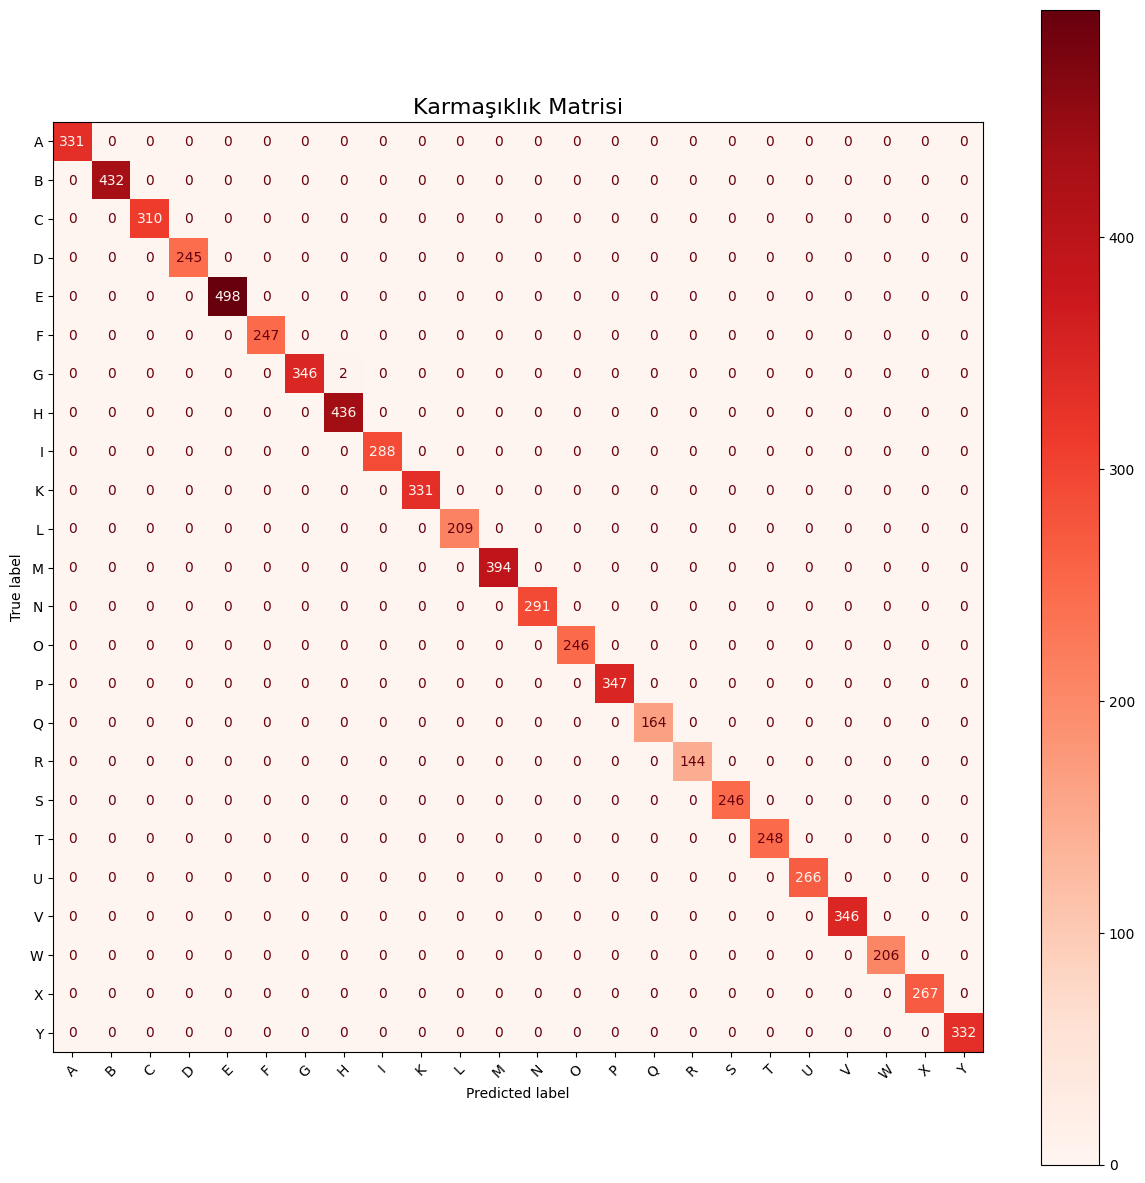

Sınıflandırma Raporu
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       331
           B       1.00      1.00      1.00       432
           C       1.00      1.00      1.00       310
           D       1.00      1.00      1.00       245
           E       1.00      1.00      1.00       498
           F       1.00      1.00      1.00       247
           G       1.00      0.99      1.00       348
           H       1.00      1.00      1.00       436
           I       1.00      1.00      1.00       288
           K       1.00      1.00      1.00       331
           L       1.00      1.00      1.00       209
           M       1.00      1.00      1.00       394
           N       1.00      1.00      1.00       291
           O       1.00      1.00      1.00       246
           P       1.00      1.00      1.00       347
           Q       1.00      1.00      1.00       164
           R       1.00      1.00      1.00       144
      

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



print("Test verisi üzerinde tahminler alınıyor")
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)


y_true = y_test_labels_remapped 


labels_full = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 
               'J', 
               'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 
               'T', 'U', 'V', 'W', 'X', 'Y', 
               'Z'] 

display_labels = [label for i, label in enumerate(labels_full) if i not in [9, 25]] 

print("Karmaşıklık Matrisi oluşturuluyor")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15, 15)) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)


disp.plot(cmap='Reds', xticks_rotation=45, ax=plt.gca()) 
plt.title('Karmaşıklık Matrisi', fontsize=16)
plt.show()

from sklearn.metrics import classification_report
print("Sınıflandırma Raporu")
print(classification_report(y_true, y_pred, target_names=display_labels, zero_division=0))

**Model mükemmele yakın bir sınıflandırma performansı göstermiştir. Yüksek doğrulukta, işaretleri karıştırmadan doğru tahmin etmiştir.**

Bu matriksi açıklamak gerekirse: A satırı A sütunu kesişimi=331.-->Model, 331 adet A işaretini doğru şekilde A işareti olarak tahmin etmiştir. 

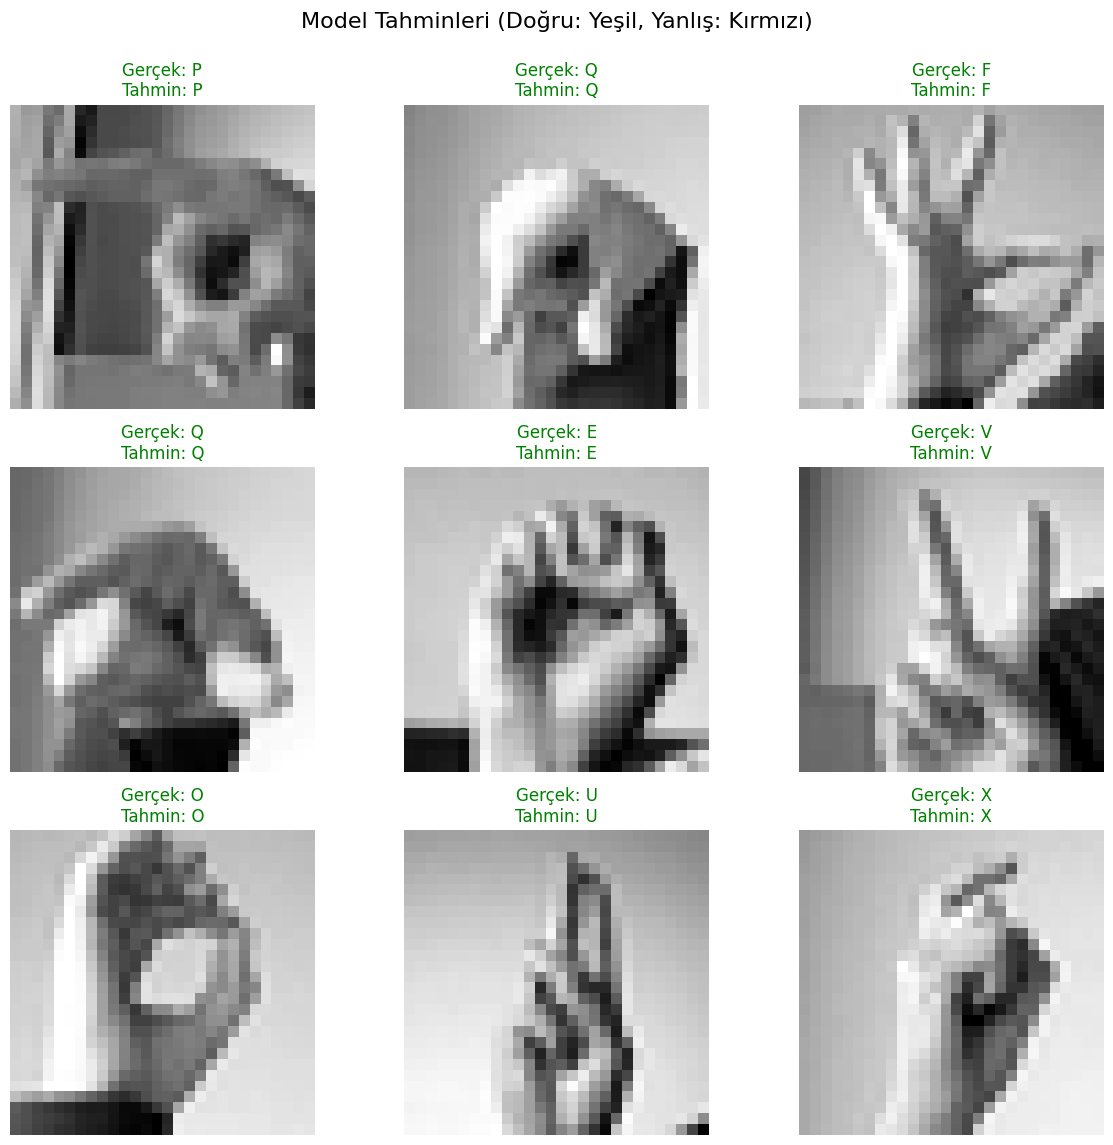

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import random


labels_full = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 
               'J', 
               'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 
               'T', 'U', 'V', 'W', 'X', 'Y', 
               'Z'] 
classes = [label for i, label in enumerate(labels_full) if i not in [9, 25]] 


images, labels = next(test_generator) 

true_labels = np.argmax(labels, axis=1) 
pred_probs = model.predict(images, verbose=0)
pred_labels = np.argmax(pred_probs, axis=1)

num_to_show = min(9, len(images))
random_indices = random.sample(range(len(images)), num_to_show)

plt.figure(figsize=(12, 12))

for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    try:
        img_data = images[idx].reshape(images.shape[1], images.shape[2])
    except:
        img_data = images[idx].reshape(48, 48) 
        
    plt.imshow(img_data, cmap='gray')
    
    is_correct = true_labels[idx] == pred_labels[idx]
    color = 'green' if is_correct else 'red'
    
    plt.title(f"Gerçek: {classes[true_labels[idx]]}\nTahmin: {classes[pred_labels[idx]]}", 
              color=color, fontsize=12)
    plt.axis('off')

plt.suptitle('Model Tahminleri (Doğru: Yeşil, Yanlış: Kırmızı)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()   
    